In [2]:
# %load /p/home/jusers/langguth1/jureca/atmorep_github/atmorep/atmorep/applications/datasets/downscaling_data_loader.py
####################################################################################################
#
#  Copyright (C) 2022
#
####################################################################################################
#
#  project     : atmorep
#
#  author      : atmorep collaboration
# 
#  description :
#
#  license     :
#
####################################################################################################

import torch
import numpy as np
import zarr
import pandas as pd
import xarray as xr
from datetime import datetime
import time
import os, sys
from pathlib import Path

In [3]:
#sys.path.insert(0, "/p/project/deepacf/atmo-rep/langguth1/atmo-rep/atmorep/")
sys.path.insert(0, "/p/project/deepacf/atmo-rep/patnala1/atmorep/")
from atmorep.datasets.normalizer import normalize
from atmorep.utils.utils import tokenize, get_weights
from atmorep.applications.downscaling.utils.era5_imerg_data_aligner import lat_lon_time_range
from atmorep.utils.logger import logger

In [4]:
def math_to_geolats(lats_math):
    """
    Convert 'mathematical' latitudes as used in AtmoRep to geographical latitudes.
    Example conversions:
        Mathematical latitude: 0° -> Geographical latitude: 90°N
        Mathematical latitude: 180° -> Geographical latitude: -90°N/90°S
    :param lats_math: 1D-array with mathematical latitudes
    :return lats_geo: 1D-array with geographical latitudes
    """
    lats_geo = np.where(lats_math > 90, -lats_math + 90, np.abs(lats_math - 90.))

    return lats_geo

def geo_to_mathlats(lats_geo):
    """
    Convert geographical latitude to 'mathematical' latitudes as used in AtmoRep.
    Example conversions:
        Geographical latitude: 90°N ->  Mathematical latitude: 0°N
        Geographical latitude: -90°N -> Mathematical latitude: 180°
    :param lats_math: 1D-array with geographical latitudes
    :return lats_geo: 1D-array with mathematical latitudes
    """
    lats_math = np.where(lats_geo > 0, np.abs(lats_geo - 90), -lats_geo + 90.)
    return lats_math

def get_latlon_arr(lat_range, lon_range, res):
    lats = np.arange(lat_range[0], lat_range[1] + res/10., res)
    lons = np.arange(lon_range[0], lon_range[1] + res/10., res)

    return lats, lons

In [5]:
class MultifieldDownscalingSampler( torch.utils.data.IterableDataset):
    
    def __init__(self, input_file_path, target_file_path, input_fields,
        target_fields, years, batch_size, n_size, num_samples, downscaling_ratio,
        with_shuffle=False, with_source_idxs = True, with_target_idxs=True) :
            super(MultifieldDownscalingSampler, self).__init__()

            self.input_fields = input_fields
            self.target_fields = target_fields
            self.n_size = n_size
            self.num_samples = num_samples
            self.with_source_idxs = with_source_idxs
            self.with_target_idxs = with_target_idxs
            self.batch_size = batch_size
            self.with_shuffle = with_shuffle
            self.downscaling_ratio = downscaling_ratio
      
            assert os.path.exists(input_file_path), f"Input file path {input_file_path} does not exist"
            assert os.path.exists(target_file_path), f"Target file path {target_file_path} does not exist"

            self.era5_ds = zarr.group(input_file_path)
            self.imerg_ds = zarr.group(target_file_path)

            self.era5_res = self.era5_ds.attrs['res']
            self.imerg_res = self.imerg_ds.attrs['res']

            self.era5_lats = np.array(self.era5_ds['lats'])
            self.era5_lons = np.array(self.era5_ds['lons'])

            self.imerg_lats = np.array(self.imerg_ds['lats'])
            self.imerg_lons = np.array(self.imerg_ds['lons'])

            self.era5_num_lats = self.era5_ds['lats'].shape[0]
            self.era5_num_lons = self.era5_ds['lons'].shape[0]
            
            self.range_lat = np.array([0,-1])
            self.range_lon = np.array([0,-1])
            self.range_time = np.array([0,-1])

            if self.era5_ds.attrs['is_global']:

                self.global_indices_range = lat_lon_time_range(
                    input_file_path,
                    target_file_path
                )
                
                lat_range = self.global_indices_range['lats']
                lon_range = self.global_indices_range['lons']
                time_range = self.global_indices_range['time']

                self.range_lat = np.array([lat_range[0], lat_range[1]])
                self.range_lon = np.array([lon_range[0], lon_range[1]])

                self.range_time = np.array([
                    time_range[0],
                    time_range[1]])
            
            self.year_base = self.era5_ds['time'][self.range_time[0]].astype(datetime).year

            # self.input_normalizers = []

            # for ifield, field_info in enumerate(input_fields):
            #     corr_type = 'global' if len(field_info) <=6 else field_info[6]
            #     nf_name = 'global_norm' if corr_type == 'global' else 'norm'
            #     self.input_normalizers.append([])
            #     for vl in field_info[2]: 
            #         if vl == 0:
            #             field_idx = self.era5_ds.attrs['fields_sfc'].index( field_info[0])
            #             n_name = f'normalization/{nf_name}_sfc'
            #             self.input_normalizers[ifield] += [self.era5_ds[n_name].oindex[ :, :, field_idx]] 
            #         else:
            #             vl_idx = self.era5_ds.attrs['levels'].index(vl)
            #             field_idx = self.era5_ds.attrs['fields'].index( field_info[0])
            #             n_name = f'normalization/{nf_name}'
            #             self.input_normalizers[ifield] += [self.era5_ds[n_name].oindex[ :, :, field_idx, vl_idx] ]


            # self.target_normalizers = []

            # for ifield, field_info in enumerate(target_fields):
            #     corr_type = 'global' if len(field_info) <=6 else field_info[6]
            #     nf_name = 'global_norm' if corr_type == 'global' else 'norm'
            #     self.target_normalizers.append([])
            #     for vl in field_info[2]: 
            #         if vl == 0:
            #             field_idx = self.imerg_ds.attrs['fields_sfc'].index( field_info[0])
            #             n_name = f'normalization/{nf_name}_sfc'
            #             self.target_normalizers[ifield] += [self.imerg_ds[n_name].oindex[ :, :, field_idx]] 
            #         else:
            #             vl_idx = self.target_ds.attrs['levels'].index(vl)
            #             field_idx = self.imerg_ds.attrs['fields'].index( field_info[0])
            #             n_name = f'normalization/{nf_name}'
            #             self.target_normalizers[ifield] += [self.imerg_ds[n_name].oindex[ :, :, field_idx, vl_idx] ]


            years_input_file = np.asarray(
                pd.DataFrame(
                    {'time' : pd.to_datetime(self.era5_ds['time'][self.range_time[0]:self.range_time[1]])})['time'].dt.strftime("%Y"))

            logical_array = np.where(years_input_file == str(years[0]), True, False)

            if len(years) > 1:
                for year in range(years[0],years[1])[1:] :
                    logical_array = np.logical_or(logical_array,
                         np.where(years_input_file == str(year), True, False))
        
            #self.valid_time_indices = np.where(logical_array)[0]
            self.valid_time_indices = np.arange(self.range_time[0],self.range_time[1])[logical_array]
            self.num_samples = min( self.num_samples, self.valid_time_indices.shape[0] - n_size[0])
            

    def shuffle(self):

        worker_info = torch.utils.data.get_worker_info()
        rng_seed = None

        if worker_info is not None:
            rng_seed = int(time.time()) // (worker_info.id+1) + worker_info.id

        rng = np.random.default_rng( rng_seed)
        self.idx_perm_era5_t = rng.permutation( 
            self.valid_time_indices[self.n_size[0]:])[: self.num_samples // self.batch_size]

        #self.idx_perm_imerg_t = np.arange(self.range_time[1]-self.range_time[0])[self.idx_perm_era5_t]
        self.idx_perm_imerg_t = self.idx_perm_era5_t - self.range_time[0]
        era5_lats = np.arange(self.range_lat[0],self.range_lat[1]-self.n_size[1])
        
        if self.range_lon[1] > self.range_lon[0]:
            era5_lons = np.arange(self.range_lon[0], self.range_lon[1]-self.n_size[2])
        else:
            era5_lons = np.arange(self.range_lon[0], self.range_lon[1]+self.era5_num_lons-self.n_size[2])

        imerg_lats_based_on_era5 = np.random.choice( np.arange(0, self.range_lat[1]-self.n_size[1]-self.range_lat[0]), size=(self.num_samples,), replace=False)
        
        if self.range_lon[1] < self.range_lon[0]:
            imerg_lons_based_on_era5 = np.random.choice( np.arange(0, self.range_lon[1]+self.era5_num_lons-self.n_size[2]-self.range_lon[0]), size=(self.num_samples,),replace=False)
        else:
            imerg_lons_based_on_era5 = np.random.choice( np.arange(0, self.range_lon[1]-self.n_size[2]-self.range_lon[0]), size=(self.num_samples,),replace=False)

        era5_selected_lats = era5_lats[imerg_lats_based_on_era5]
        era5_selected_lons = era5_lons[imerg_lons_based_on_era5]

        self.idxs_perm_era5 = np.stack( [era5_selected_lats,era5_selected_lons], axis=1)
        self.idxs_perm_imerg = np.stack( [imerg_lats_based_on_era5, imerg_lons_based_on_era5], axis=1)

    def __iter__(self):
        
        if self.with_shuffle:
            self.shuffle()
        
        lats, lons = self.era5_lats, self.era5_lons
        n_size = self.n_size
        res = self.era5_res

        iter_start , iter_end = self.worker_workset()

        for bidx in range( iter_start, iter_end):

            sources, token_infos = [[] for _ in self.input_fields], [[] for _ in self.input_fields]
            targets, target_token_infos = [[] for _ in self.target_fields], [[] for _ in self.target_fields],
            sources_infos, source_idxs = [], []
            target_infos, target_idxs = [], []

            i_bidx = self.idx_perm_era5_t[bidx]
            i_bidx_imerg = self.idx_perm_imerg_t[bidx]

            idxs_t_era5 = [i_bidx - n_size[0], i_bidx]
            idxs_t_imerg = [i_bidx_imerg - n_size[0], i_bidx_imerg]

            data_t = self.era5_ds['time'][idxs_t_era5[0]:idxs_t_era5[1]].astype(datetime)

            data_era5_tt_sfc = self.era5_ds['data_sfc'][idxs_t_era5[0]:idxs_t_era5[1]]
            data_era5_tt = self.era5_ds['data'][idxs_t_era5[0]:idxs_t_era5[1]]

            data_imerg_tt_sfc = self.imerg_ds['data_sfc'][idxs_t_imerg[0]:idxs_t_imerg[1]]

            for sidx in range(self.batch_size):

                idx_era5 = self.idxs_perm_era5[bidx*self.batch_size+sidx]

                idx_lat_era5 = [idx_era5[0], idx_era5[0] + n_size[1]]
                idx_lon_era5 = [idx_era5[1], idx_era5[1] + n_size[2]]

                lon_list = None

                if idx_lon_era5[0] > self.era5_num_lons - n_size[2] and idx_lon_era5[0] < self.era5_num_lons:
                    lon_list = np.arange(idx_lon_era5[0], self.era5_num_lons)
                    lon_list = np.concatenate((lon_list,np.arange(0,idx_lon_era5[1]%self.era5_num_lons)))

                if idx_lon_era5[0] >= self.era5_num_lons:
                    idx_lon_era5[0] = idx_lon_era5[0]%self.era5_num_lons
                    idx_lon_era5[1] = idx_lon_era5[1]%self.era5_num_lons
            
                sources_infos += [ [ self.era5_ds['time'][idxs_t_era5[0]:idxs_t_era5[1]].astype(datetime),
                                     self.era5_ds['lats'][idx_lat_era5[0]:idx_lat_era5[1]],
                                     self.era5_ds['lons'][np.arange(idx_lon_era5[0],idx_lon_era5[1]) if lon_list is None else lon_list],
                                     self.era5_res ] ]
                
                if self.with_source_idxs :
                    source_idxs += [ (np.arange(idxs_t_era5[0],idxs_t_era5[1]),
                                      np.arange(idx_lat_era5[0],idx_lat_era5[1]),
                                      np.arange(idx_lon_era5[0],idx_lon_era5[1]) if lon_list is None else np.array(lon_list) ) ]
                

                idx_imerg = self.idxs_perm_imerg[bidx*self.batch_size+sidx]

                idx_lat_imerg = [idx_imerg[0]*self.downscaling_ratio, (idx_imerg[0] + n_size[1])*self.downscaling_ratio]
                idx_lon_imerg = [idx_imerg[1]*self.downscaling_ratio, (idx_imerg[1] + n_size[2])*self.downscaling_ratio]
                target_infos += [ [ self.imerg_ds['time'][idxs_t_imerg[0]:idxs_t_imerg[1]].astype(datetime),
                                    self.imerg_ds['lats'][idx_lat_imerg[0]:idx_lat_imerg[1]],
                                    self.imerg_ds['lons'][idx_lon_imerg[0]:idx_lon_imerg[1]],
                                    self.imerg_res ] ]

                if self.with_target_idxs :
                    target_idxs += [ (np.arange(idxs_t_imerg[0],idxs_t_imerg[1]),
                                      np.arange(idx_lat_imerg[0],idx_lat_imerg[1]),
                                      np.arange(idx_lon_imerg[0],idx_lon_imerg[1]) ) ]
                                      

                for ifield, field_info in enumerate(self.input_fields):
                    source_lvl, tok_info_lvl = [], []
                    tok_size = field_info[4]
                    num_tokens = field_info[3]

                    corr_type = 'global' if len(field_info) <=6 else field_info[6]

                    for ilevel, vl in enumerate(field_info[2]):
                        if vl == 0:
                            field_idx = self.era5_ds.attrs['fields_sfc'].index( field_info[0])
                            data_t = data_era5_tt_sfc[:,field_idx]
                        else:
                            field_idx = self.era5_ds.attrs['fields'].index( field_info[0])
                            vl_idx = self.era5_ds.attrs['levels'].index( vl)
                            data_t = data_era5_tt[:,field_idx, vl_idx]
                        
                        source_data, tok_info = [], []
                        
                        cdata = data_t[ :, 
                                 idx_lat_era5[0]:idx_lat_era5[1], 
                                 list(np.arange(idx_lon_era5[0],idx_lon_era5[1])) if lon_list is None else lon_list] 

                        
                        # normalizer = self.input_normalizers[ifield][ilevel]
                        
                        # if corr_type != 'global':
                        #     normalizer = normalizer[ : , : , 
                        #            idx_lat_era5[0]:idx_lat_era5[1] ,
                        #            list(np.arange(idx_lon_era5[0],idx_lon_era5[1])) if lon_list is None else lon_list]
                        
                        # removed normalize and tokenize for test purpose
                        #cdata = normalize(cdata, normalizer, sources_infos[-1][0], year_base = self.year_base)
                        
                        #source_data = tokenize( torch.from_numpy( cdata), tok_size)
                        
                        source_data = cdata #need to remove this line once the test is done

                        dates = self.era5_ds['time'][ idxs_t_era5[0]:idxs_t_era5[1]].astype(datetime)
                        cdates = dates[tok_size[0]-1::tok_size[0]]

                        dates = [(d.year, d.timetuple().tm_yday-1, d.hour) for d in cdates]
                        lats_sidx = self.era5_ds['lats'][idx_lat_era5[0]: idx_lat_era5[1]][tok_size[1]//2 :: tok_size[1] ]
                        if lon_list is None:
                            lons_sidx = self.era5_ds['lons'][idx_lon_era5[0]: idx_lon_era5[1]][tok_size[2]//2 :: tok_size[2] ]
                        else:
                            lons_sidx = self.era5_ds['lons'][lon_list][tok_size[2]//2 :: tok_size[2]]

                        tok_info += [[[[[ year, day, hour, vl, lat, lon, vl, self.era5_res[0]] for lon in lons_sidx]
                                                                              for lat in lats_sidx]
                                                                  for (year, day, hour) in dates]]                                                       
                        source_lvl += [ torch.tensor(source_data) ]
                        
                        tok_info_lvl += [torch.tensor( tok_info, dtype=torch.float32).flatten( 1,-2)]

                    sources[ifield] += [ torch.stack(source_lvl, 0) ]
                    token_infos[ifield] += [ torch.stack(tok_info_lvl, 0)]
                
                for ifield, field_info in enumerate(self.target_fields):
                    #target_lvl, target_tok_info_lvl = [], []
                    target_lvl = []
                    target_tok_size = field_info[4]
                    target_num_tokens = field_info[3]

                    for ilevel, vl in enumerate(field_info[2]):
                        if vl == 0:
                            field_idx = self.imerg_ds.attrs['fields_sfc'].index( field_info[0])
                            data_t_imerg = data_imerg_tt_sfc[:,field_idx]
                        else:
                            field_idx = self.imerg_ds.attrs['fields'].index( field_info[0])
                            vl_idx = self.imerg_ds.attrs['levels'].index( vl)
                            data_t_imerg = data_imerg_tt[:,field_idx, vl_idx]

                        target_data, target_tok_info = [], []

                        cdata_imerg = data_t_imerg[ :, 
                                        idx_lat_imerg[0]:idx_lat_imerg[1],
                                        idx_lon_imerg[0]:idx_lon_imerg[1] ]
                        
                        # normalizer = self.target_normalizers[ifield][ilevel]
                        
                        # if corr_type != 'global':
                        #     normalizer = normalizer[ : , : , 
                        #            idx_lat_era5[0]:idx_lat_era5[1] ,
                        #            idx_lon_era5[0]:idx_lon_era5[1]]

                        #uncomment these lines after testing
                        #cdata_imerg = normalize(cdata_imerg, normalizer, target_infos[-1][0], year_base = self.year_base)
                        
                        #target_data = tokenize( torch.from_numpy( cdata_imerg), target_tok_size)

                        target_data = cdata_imerg #remove this line once testing is done

                        ##need to fill based on how the positional encoding needs to be done for output_latent_arrays
                        target_lvl += [ torch.tensor(target_data) ]
                        #target_tok_info_lvl += [np.array([0])]

                    targets[ifield] += [torch.stack(target_lvl, 0)]
                    #target_token_infos[ifield] += [ torch.stack(target_tok_info_lvl, 0)]

            sources = [torch.stack(sources_field) for sources_field in sources]
            token_infos = [torch.stack(tis_field) for tis_field in token_infos]

            targets = [torch.stack(targets_field) for targets_field in targets]
            #target_token_infos = [torch.stack(target_tis_field).transpose(1,0) for target_tis_field in target_token_infos]
            
            yield ((sources, token_infos), (source_idxs, sources_infos), targets, (target_idxs,target_infos))          # (targets, target_token_infos))
  
    def __len__(self):
        return self.num_samples // self.batch_size


    def worker_workset( self) :

        worker_info = torch.utils.data.get_worker_info()

        if worker_info is None: 
            iter_start = 0
            iter_end = self.num_samples
    
        else:  
            # split workload
            per_worker = len(self) // worker_info.num_workers
            worker_id = worker_info.id
            iter_start = int(worker_id * per_worker)
            iter_end = int(iter_start + per_worker)
            if worker_info.id+1 == worker_info.num_workers :
                iter_end = len(self)

        return iter_start, iter_end

In [6]:
from atmorep.utils.utils import Config

cf = Config()

#cf.model_id = "3kdutwqb" 
cf.fields = [["velocity_u", [1, 2048, ["velocity_v", "temperature", "specific_humidity", "velocity_z"], 0, ["3k6e6p7o", 141]], [96, 105, 114, 123, 137], [12, 6, 12], [3, 9, 9], [0.7, 0.9, 0.2, 0.05], "local"], 
             ["velocity_v", [1, 2048, ["velocity_u", "temperature", "specific_humidity", "velocity_z"], 1, ["brxmevmt", 141]], [96, 105, 114, 123, 137], [12, 6, 12], [3, 9, 9], [0.7, 0.9, 0.2, 0.05], "local"], 
             ["specific_humidity", [1, 2048, ["velocity_u", "velocity_v", "velocity_z", "temperature", "total_precip"], 2, ["ctxc97nr", 128]], [96, 105, 114, 123, 137], [12, 6, 12], [3, 9, 9], [0.85, 0.9, 0.2, 0.05], "local"], 
             ["velocity_z", [1, 1024, ["velocity_u", "velocity_v", "temperature"], 0, ["15oisw8d", 273]], [96, 105, 114, 123, 137], [12, 6, 12], [3, 9, 9], [0.65, 0.9, 0.2, 0.05], "global"],
             ["temperature", [1, 1536, ["velocity_u", "velocity_v", "velocity_z", "specific_humidity"], 3, ["3qou60es", 327]], [96, 105, 114, 123, 137], [12, 2, 4], [3, 27, 27], [0.85, 0.9, 0.2, 0.05], "local"],
             ["total_precip", [1, 1536, ["velocity_u", "velocity_v", "velocity_z", "specific_humidity"], 3, ["3kdutwqb", 900]], [0], [12, 6, 12], [3, 9, 9], [0.5, 0.9, 0.1, 0.05]]]
cf.input_fields = cf.fields

cf.downscaling_ratio = 3
cf.fields_downscaling = [ ['total_precip', 
                        [1,1536,["velocity_u","velocity_v","specific_humidity"]],
                        [0],
                        [12,6,12],
                        [3,9*cf.downscaling_ratio,9*cf.downscaling_ratio], 
                        1.0 ] ]
cf.target_fields = cf.fields_downscaling
cf.input_file_path = "/p/scratch/atmo-rep/data/era5_1deg/months/era5_y1979_2021_res025_chunk8.zarr"
cf.target_file_path = "/p/scratch/atmo-rep/data/imerg/imerg_regridded/imerg_regrid_y2003_2021_res083_chunk8.zarr"
cf.years_train = [2003,2020]
cf.years_val = [2021]  #[2018] 
cf.month = None
cf.batch_size = 8
cf.num_samples_per_epoch = 24
cf.n_size = [36, 9*6, 9*12]

In [7]:
cf.downscaling_ratio

3

In [8]:
downscaling_dataset = MultifieldDownscalingSampler(
                    cf.input_file_path,
                    cf.target_file_path,
                    cf.fields,
                    cf.target_fields,
                    cf.years_train,
                    cf.batch_size,
                    cf.n_size,
                    cf.num_samples_per_epoch,
                    cf.downscaling_ratio,
                    with_shuffle=True
        )

In [9]:
iter_ds = iter(downscaling_dataset)

In [10]:
(sources, token_infos), (source_idxs, sources_infos), targets, (target_idxs,target_infos) = next(iter_ds)

In [13]:
sources_infos[0], target_infos[0]

([array([datetime.datetime(2008, 12, 22, 19, 0),
         datetime.datetime(2008, 12, 22, 20, 0),
         datetime.datetime(2008, 12, 22, 21, 0),
         datetime.datetime(2008, 12, 22, 22, 0),
         datetime.datetime(2008, 12, 22, 23, 0),
         datetime.datetime(2008, 12, 23, 0, 0),
         datetime.datetime(2008, 12, 23, 1, 0),
         datetime.datetime(2008, 12, 23, 2, 0),
         datetime.datetime(2008, 12, 23, 3, 0),
         datetime.datetime(2008, 12, 23, 4, 0),
         datetime.datetime(2008, 12, 23, 5, 0),
         datetime.datetime(2008, 12, 23, 6, 0),
         datetime.datetime(2008, 12, 23, 7, 0),
         datetime.datetime(2008, 12, 23, 8, 0),
         datetime.datetime(2008, 12, 23, 9, 0),
         datetime.datetime(2008, 12, 23, 10, 0),
         datetime.datetime(2008, 12, 23, 11, 0),
         datetime.datetime(2008, 12, 23, 12, 0),
         datetime.datetime(2008, 12, 23, 13, 0),
         datetime.datetime(2008, 12, 23, 14, 0),
         datetime.datetime(200

In [27]:
sample_idx = 4
era5_sample = sources[-1][sample_idx,0]
imerg_sample = targets[0][sample_idx,0]

In [28]:
precip_era5 = xr.DataArray(era5_sample*1000., dims=["time", "lat", "lon"], 
                           coords={"time": sources_infos[sample_idx][0], "lat": math_to_geolats(sources_infos[sample_idx][1]), "lon": np.where(sources_infos[sample_idx][2] >180.0,
                                                                                                                                               sources_infos[sample_idx][2] - 360.0,
                                                                                                                                               sources_infos[sample_idx][2])})

precip_imerg = xr.DataArray(imerg_sample, dims=["time", "lat", "lon"], 
                           coords={"time": target_infos[sample_idx][0], "lat": math_to_geolats(target_infos[sample_idx][1]), "lon": target_infos[sample_idx][2]})

In [29]:
precip_era5['lat'], precip_imerg['lat']

(<xarray.DataArray 'lat' (lat: 54)>
 array([47.75, 47.5 , 47.25, 47.  , 46.75, 46.5 , 46.25, 46.  , 45.75, 45.5 ,
        45.25, 45.  , 44.75, 44.5 , 44.25, 44.  , 43.75, 43.5 , 43.25, 43.  ,
        42.75, 42.5 , 42.25, 42.  , 41.75, 41.5 , 41.25, 41.  , 40.75, 40.5 ,
        40.25, 40.  , 39.75, 39.5 , 39.25, 39.  , 38.75, 38.5 , 38.25, 38.  ,
        37.75, 37.5 , 37.25, 37.  , 36.75, 36.5 , 36.25, 36.  , 35.75, 35.5 ,
        35.25, 35.  , 34.75, 34.5 ])
 Coordinates:
   * lat      (lat) float64 47.75 47.5 47.25 47.0 46.75 ... 35.25 35.0 34.75 34.5,
 <xarray.DataArray 'lat' (lat: 162)>
 array([47.833333, 47.75    , 47.666667, 47.583333, 47.5     , 47.416667,
        47.333333, 47.25    , 47.166667, 47.083333, 47.      , 46.916667,
        46.833333, 46.75    , 46.666667, 46.583333, 46.5     , 46.416667,
        46.333333, 46.25    , 46.166667, 46.083333, 46.      , 45.916667,
        45.833333, 45.75    , 45.666667, 45.583333, 45.5     , 45.416667,
        45.333333, 45.25    , 45.

In [30]:
precip_era5['lon'], precip_imerg['lon']

(<xarray.DataArray 'lon' (lon: 108)>
 array([ 4.25,  4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,
         6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,  9.  ,
         9.25,  9.5 ,  9.75, 10.  , 10.25, 10.5 , 10.75, 11.  , 11.25, 11.5 ,
        11.75, 12.  , 12.25, 12.5 , 12.75, 13.  , 13.25, 13.5 , 13.75, 14.  ,
        14.25, 14.5 , 14.75, 15.  , 15.25, 15.5 , 15.75, 16.  , 16.25, 16.5 ,
        16.75, 17.  , 17.25, 17.5 , 17.75, 18.  , 18.25, 18.5 , 18.75, 19.  ,
        19.25, 19.5 , 19.75, 20.  , 20.25, 20.5 , 20.75, 21.  , 21.25, 21.5 ,
        21.75, 22.  , 22.25, 22.5 , 22.75, 23.  , 23.25, 23.5 , 23.75, 24.  ,
        24.25, 24.5 , 24.75, 25.  , 25.25, 25.5 , 25.75, 26.  , 26.25, 26.5 ,
        26.75, 27.  , 27.25, 27.5 , 27.75, 28.  , 28.25, 28.5 , 28.75, 29.  ,
        29.25, 29.5 , 29.75, 30.  , 30.25, 30.5 , 30.75, 31.  ])
 Coordinates:
   * lon      (lon) float64 4.25 4.5 4.75 5.0 5.25 ... 30.0 30.25 30.5 30.75 31.0,
 <xarray.DataArray 'l

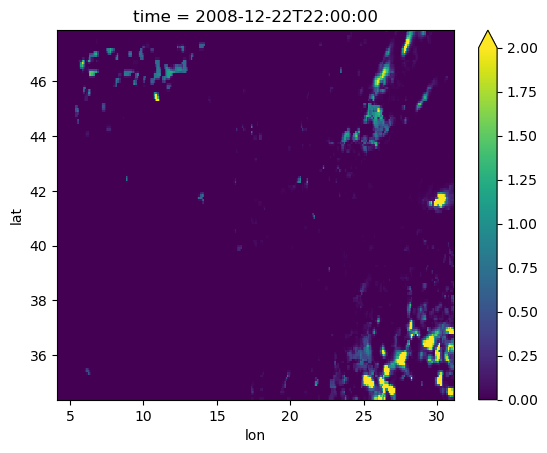

In [31]:
%matplotlib inline

# parameters for plotting
tidx = 3
val_range = {"vmin": 0, "vmax": 2.}

precip_imerg.isel({"time": tidx}).plot(**val_range)

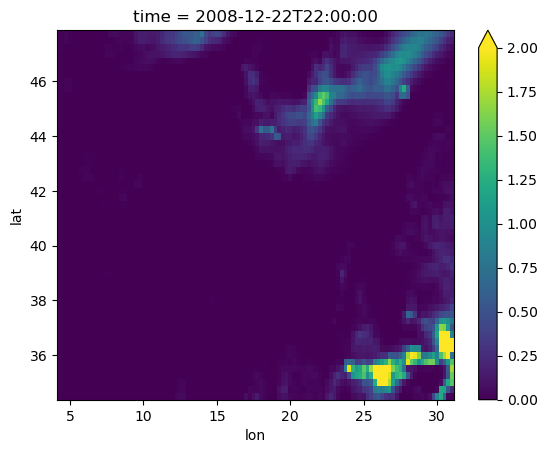

In [32]:
precip_era5.isel({"time": tidx}).plot(**val_range)

# Michael's code to generate data from token information

In [17]:
isample = 3

imerg_sample = (targets[0].numpy())[isample, 0, ...]
era5_sample = (sources[-1].numpy())[isample, 0, ...]

In [18]:
year, day, hour = tuple(token_infos[-1].numpy()[isample, 0, 0, 0][0:3])

date_start = pd.to_datetime(year * 1000 + day, format='%Y%j')
date_start = date_start + pd.to_timedelta(hour, unit='h') - pd.to_timedelta(1, unit='h')
all_dates = pd.date_range(date_start, periods=36, freq="1h")

# sanity check
year, day, hour = tuple(token_infos[-1].numpy()[isample,0,0,-1][0:3])

date_end = pd.to_datetime(year * 1000 + day, format='%Y%j')
date_end = date_end + pd.to_timedelta(hour, unit='h') + pd.to_timedelta(1, unit='h')

assert all_dates[-1] == date_end, "Inconsistent date information retrieved from token info"

In [19]:
date_start, date_end

(Timestamp('2018-12-13 07:00:00'), Timestamp('2018-12-14 18:00:00'))

In [20]:
lat_min, lat_max = token_infos[-1].numpy()[0, 0, 0, 0][[4]], token_infos[-1].numpy()[0, 0, 0, -1][[4]]
lon_min, lon_max = token_infos[-1].numpy()[0, 0, 0, 0][[5]], token_infos[-1].numpy()[0, 0, 0, -1][[5]]

if lon_min > lon_max:
    lon_min -= 360.

lat_range_era5 = [lat_min[0] - 4*0.25, lat_max[0] + 4*.25]
lon_range_era5 = [lon_min[0] - 4*0.25, lon_max[0] + 4*.25]

lat_range_imerg = [lat_range_era5[0] - 0.25/3, lat_range_era5[1] + 0.25/3]
lon_range_imerg = [lon_range_era5[0] - 0.25/3, lon_range_era5[1] + 0.25/3]

In [21]:
lats_era5, lons_era5 = get_latlon_arr(lat_range_era5, lon_range_era5, .25)
lats_imerg, lons_imerg = get_latlon_arr(lat_range_imerg, lon_range_imerg, .25/3)

In [22]:
precip_era5 = xr.DataArray(era5_sample*1000., dims=["time", "lat", "lon"], 
                           coords={"time": all_dates, "lat": math_to_geolats(lats_era5), "lon": lons_era5})

precip_imerg = xr.DataArray(imerg_sample, dims=["time", "lat", "lon"], 
                           coords={"time": all_dates, "lat": math_to_geolats(lats_imerg), "lon": lons_imerg})

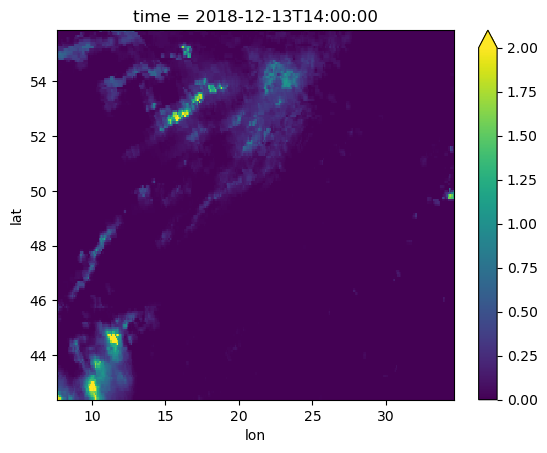

In [36]:
%matplotlib inline

# parameters for plotting
tidx = 7
val_range = {"vmin": 0, "vmax": 2.}

precip_imerg.isel({"time": tidx}).plot(**val_range)

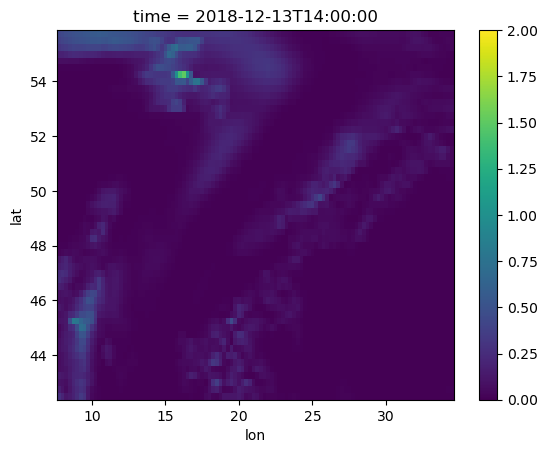

In [37]:
precip_era5.isel({"time": tidx}).plot(**val_range)

# From Ankit's checkpointed files

In [129]:
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt

datadir = Path("/p/project1/deepacf/atmo-rep/patnala1/nc_files_new")
ds_imerg = xr.open_dataset(datadir.joinpath("imerg_25722_44_78.nc"))
ds_era5 = xr.open_dataset(datadir.joinpath("era_5_25722_109_2.nc"))

precip_era5 = ds_era5["total_precip"]
precip_imerg = ds_imerg["total_precip"]

In [130]:
%matplotlib inline

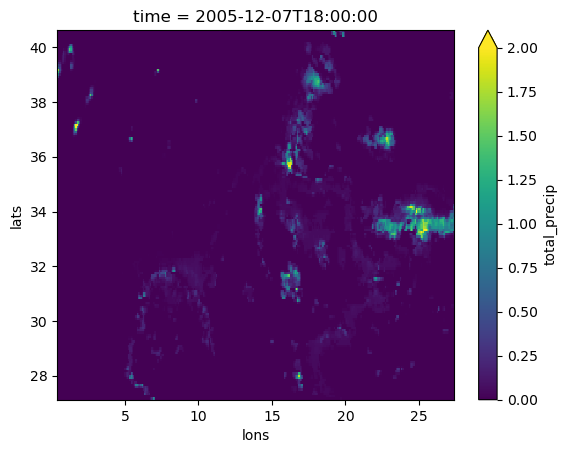

In [131]:
tidx = 0

ds_imerg["total_precip"].isel({"time": tidx}).plot(vmin=0., vmax=2.)

plt.show()

In [132]:
ds_era5["lons"] = ds_era5["lons"].where(ds_era5["lons"] < 180., ds_era5["lons"] - 360.)

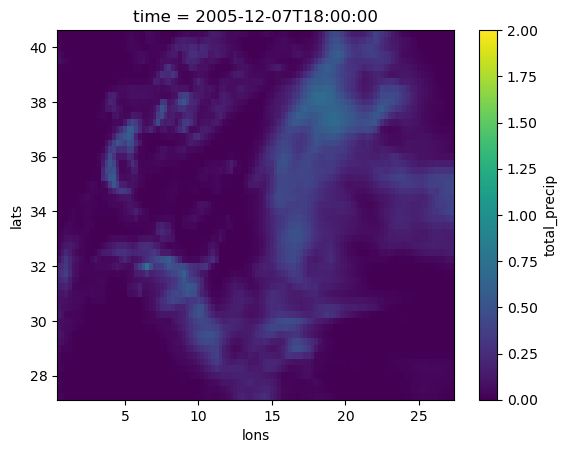

In [133]:
ds_era5["total_precip"].isel({"time": tidx}).plot(vmin=0., vmax=2.)

# Plot data from raw datafiles 

In [33]:
datadir_imerg_raw = Path("/p/scratch/atmo-rep/data/imerg/imerg_regridded")
datadir_era5_raw = Path("/p/scratch/atmo-rep/data/era5/new_structure/total_precip/ml0")

date_now = pd.to_datetime(precip_era5["time"][tidx].values)
ym_str = date_now.strftime("y%Y_m%m")

fname_imerg_raw = datadir_imerg_raw.joinpath(f"3B-HHR.MS.MRG.3IMERG.{ym_str}.nc")
fname_era5_raw = datadir_era5_raw.joinpath(f"era5_total_precip_{ym_str}_ml0.nc")

In [34]:
ds_imerg_raw = xr.open_dataset(fname_imerg_raw)
ds_era5_raw = xr.open_dataset(fname_era5_raw)

In [35]:
#lat_range = (ds_imerg["total_precip"]["lats"].values[0]-.01, ds_imerg["total_precip"]["lats"].values[-1]+.01)
#lon_range = (ds_imerg["total_precip"]["lons"].values[0]-.01, ds_imerg["total_precip"]["lons"].values[-1]+.01)

#precip_imerg_raw = ds_imerg_raw["precipitation"].sel({"lat": slice(*lat_range), "lon": slice(*lon_range), 
#                                                     "time": date_now})
offset = 0

precip_imerg_raw = ds_imerg_raw["precipitation"].sel({"lat": precip_imerg['lat'], "lon": precip_imerg['lon'], 
                                                     "time": date_now + pd.Timedelta(offset,"h")}, method='nearest')
#precip_era5_raw = ds_era5_raw["tp"].sel({"latitude": slice(*lat_range[::-1]), "longitude": slice(*lon_range), 
#                                         "time": date_now})*1000.
precip_era5_raw = ds_era5_raw["tp"].sel({"latitude": precip_era5['lat'], "longitude": precip_era5['lon'], 
                                         "time": date_now + pd.Timedelta(offset,"h")}, method='nearest')*1000.

In [36]:
#precip_era5_raw = precip_era5_raw.reindex({"latitude": precip_era5_raw["latitude"][::-1]})

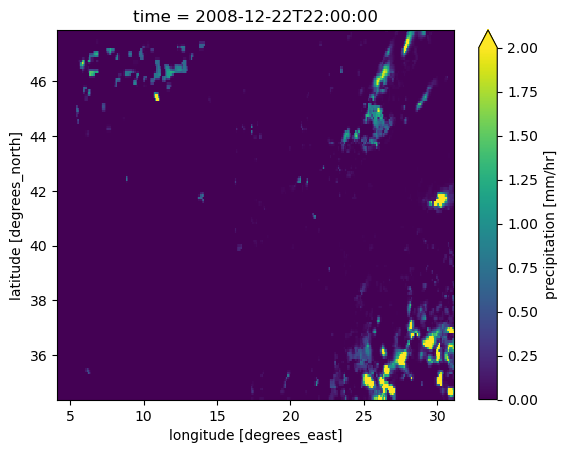

In [37]:
import matplotlib.pyplot as plt
precip_imerg_raw.plot(vmin=0., vmax=2.)

plt.show()

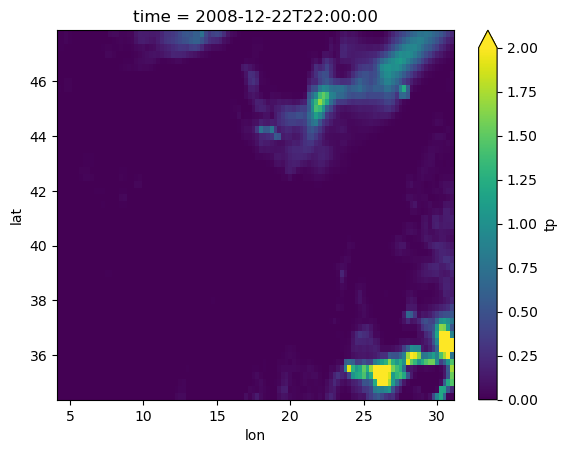

In [38]:
precip_era5_raw.plot(vmin=0., vmax=2.)

plt.show()